In [95]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [96]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [97]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [98]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [99]:
ticker='TSLA'

In [100]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [101]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [102]:
dates = pd.to_datetime(df['Date'])

In [103]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [104]:
df_for_training = df[cols].astype(float)

In [105]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [106]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [107]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [108]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [109]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [110]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [111]:
def build_model(input_shape,output_shape):
    model=Sequential()
    model.add(LSTM(64,activation='relu',input_shape=input_shape,return_sequences=False))
    model.add(Dense(output_shape))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)

Epoch 1/1000
4/4 [==============================] - 1s 45ms/step - loss: 0.0669 - val_loss: 0.1911
Epoch 2/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0616 - val_loss: 0.1813
Epoch 3/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0566 - val_loss: 0.1717
Epoch 4/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0519 - val_loss: 0.1624
Epoch 5/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0474 - val_loss: 0.1535
Epoch 6/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0433 - val_loss: 0.1448
Epoch 7/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0394 - val_loss: 0.1365
Epoch 8/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0357 - val_loss: 0.1285
Epoch 9/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0323 - val_loss: 0.1209
Epoch 10/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0291 - val_loss: 0.1136
Epoch 11/

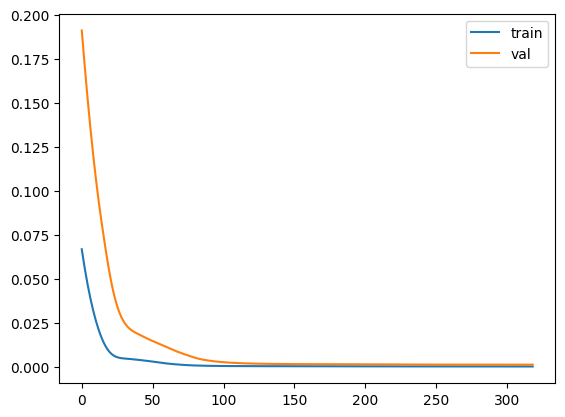

4/4 [==============================] - 0s 3ms/step
mae: 0.7601046806375961


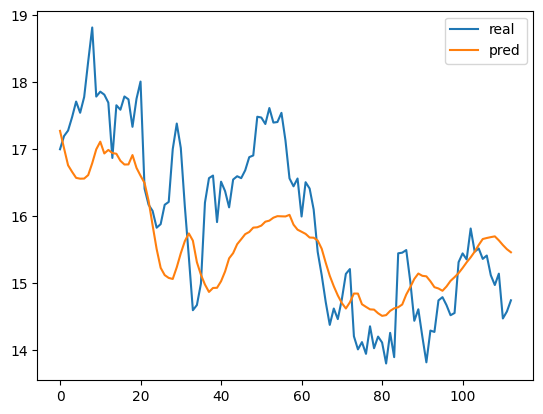

Epoch 1/1000
7/7 [==============================] - 1s 28ms/step - loss: 0.0673 - val_loss: 0.0466
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0537 - val_loss: 0.0339
Epoch 3/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0421 - val_loss: 0.0235
Epoch 4/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0324 - val_loss: 0.0153
Epoch 5/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0246 - val_loss: 0.0092
Epoch 6/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0050
Epoch 7/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0024
Epoch 8/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0109 - val_loss: 9.9814e-04
Epoch 9/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 5.4699e-04
Epoch 10/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 6.6507e-

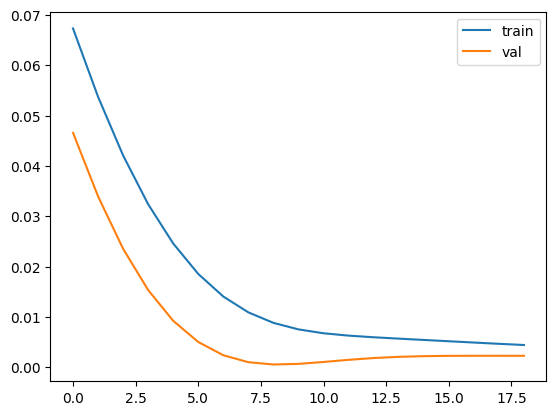

4/4 [==============================] - 0s 2ms/step
mae: 1.6722480126812689


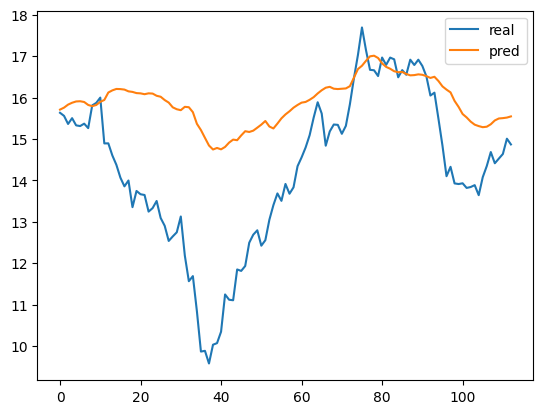

Epoch 1/1000
10/10 [==============================] - 1s 82ms/step - loss: 0.0835 - val_loss: 0.0917
Epoch 2/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0715 - val_loss: 0.0782
Epoch 3/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0607 - val_loss: 0.0656
Epoch 4/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0509 - val_loss: 0.0540
Epoch 5/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0420 - val_loss: 0.0435
Epoch 6/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0338 - val_loss: 0.0339
Epoch 7/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0265 - val_loss: 0.0255
Epoch 8/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 9/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 10/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0112 - val_lo

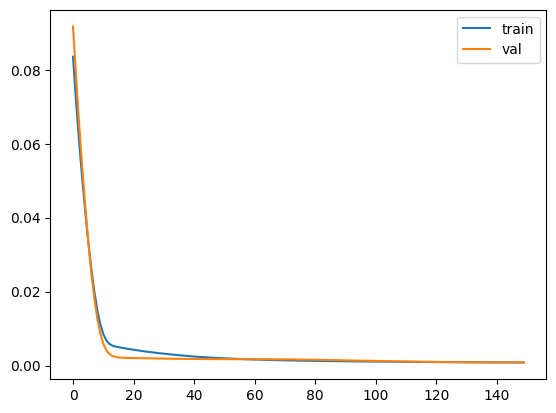

4/4 [==============================] - 0s 3ms/step
mae: 0.5013735369629986


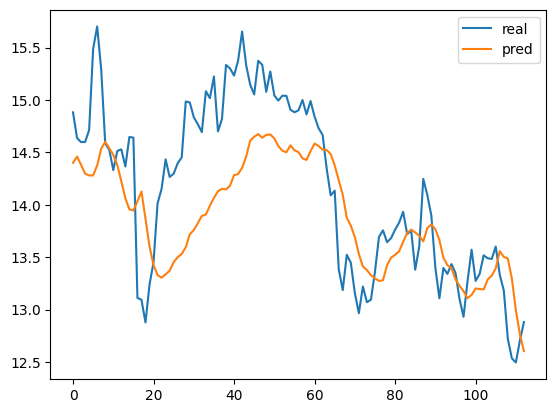

Epoch 1/1000
13/13 [==============================] - 1s 23ms/step - loss: 0.0530 - val_loss: 0.0151
Epoch 2/1000
13/13 [==============================] - 0s 15ms/step - loss: 0.0379 - val_loss: 0.0076
Epoch 3/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.0267 - val_loss: 0.0030
Epoch 4/1000
13/13 [==============================] - 0s 15ms/step - loss: 0.0184 - val_loss: 7.5830e-04
Epoch 5/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.0126 - val_loss: 3.5072e-04
Epoch 6/1000
13/13 [==============================] - 0s 15ms/step - loss: 0.0088 - val_loss: 0.0012
Epoch 7/1000
13/13 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 8/1000
13/13 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 9/1000
13/13 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 10/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.0045 

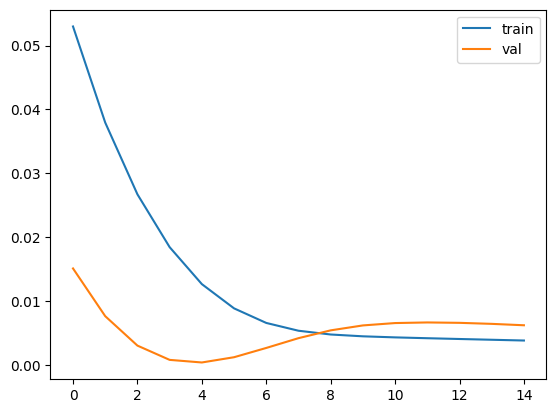

4/4 [==============================] - 0s 2ms/step
mae: 1.2112947329133972


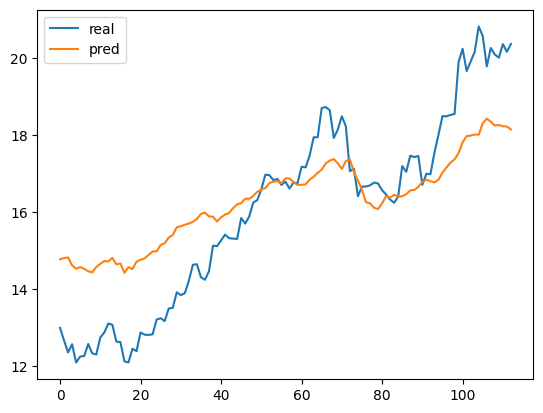

Epoch 1/1000
17/17 [==============================] - 1s 20ms/step - loss: 0.1521 - val_loss: 0.2721
Epoch 2/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.1074 - val_loss: 0.1957
Epoch 3/1000
17/17 [==============================] - 0s 15ms/step - loss: 0.0737 - val_loss: 0.1367
Epoch 4/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0484 - val_loss: 0.0914
Epoch 5/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0304 - val_loss: 0.0579
Epoch 6/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0186 - val_loss: 0.0349
Epoch 7/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 0.0206
Epoch 8/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0080 - val_loss: 0.0126
Epoch 9/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 10/1000
17/17 [==============================] - 0s 14ms/step - loss: 0.0058 - val_lo

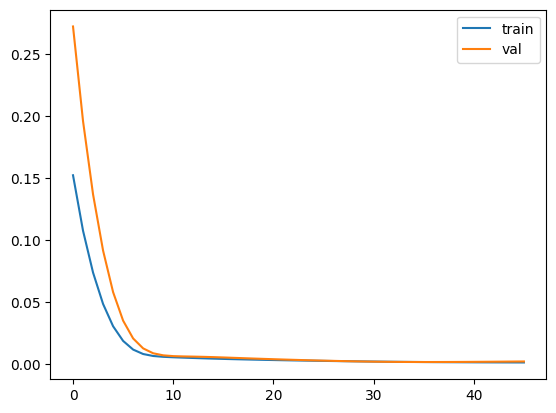

4/4 [==============================] - 0s 3ms/step
mae: 1.026770081222129


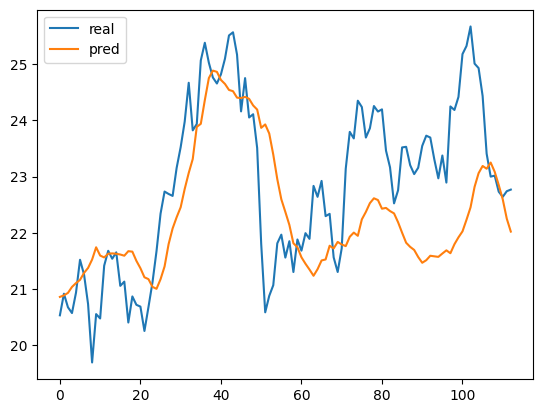

Epoch 1/1000
20/20 [==============================] - 1s 18ms/step - loss: 0.1306 - val_loss: 0.3324
Epoch 2/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0758 - val_loss: 0.2157
Epoch 3/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0421 - val_loss: 0.1333
Epoch 4/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0233 - val_loss: 0.0795
Epoch 5/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0145 - val_loss: 0.0481
Epoch 6/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0318
Epoch 7/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0094 - val_loss: 0.0242
Epoch 8/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 9/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0077 - val_loss: 0.0175
Epoch 10/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0070 - val_lo

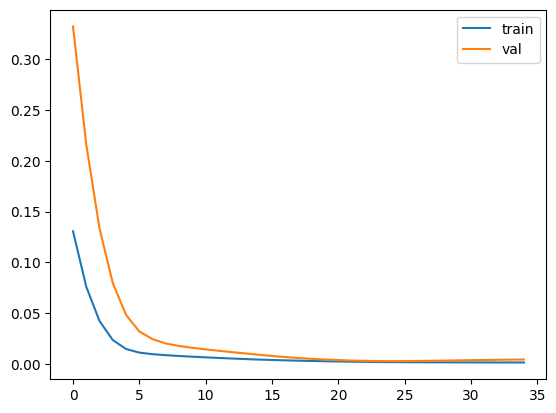

4/4 [==============================] - 0s 2ms/step
mae: 2.613724470075489


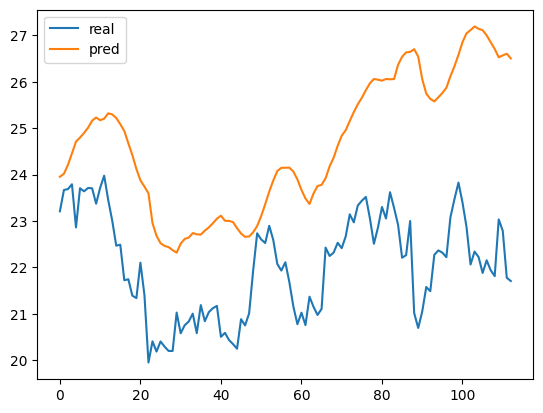

Epoch 1/1000
23/23 [==============================] - 1s 18ms/step - loss: 0.1842 - val_loss: 0.4067
Epoch 2/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.1098 - val_loss: 0.2394
Epoch 3/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0614 - val_loss: 0.1261
Epoch 4/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0310 - val_loss: 0.0534
Epoch 5/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0157 - val_loss: 0.0171
Epoch 6/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0104 - val_loss: 0.0053
Epoch 7/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0090 - val_loss: 0.0029
Epoch 8/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0024
Epoch 9/1000
23/23 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 10/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0068 - val_lo

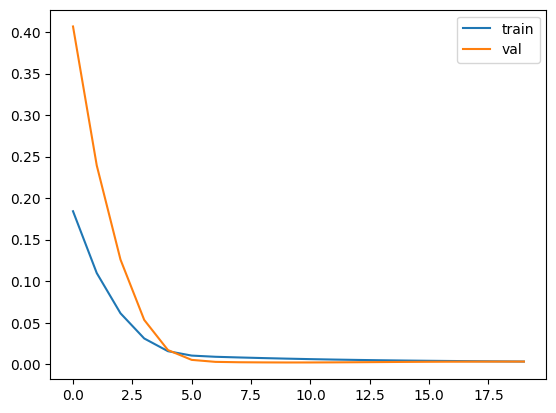

4/4 [==============================] - 0s 3ms/step
mae: 3.4536535587482278


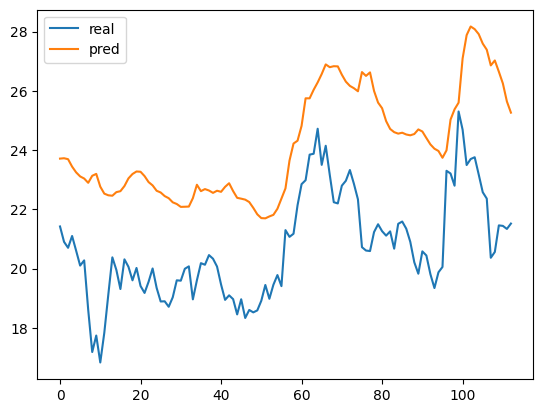

Epoch 1/1000
26/26 [==============================] - 1s 16ms/step - loss: 0.1260 - val_loss: 0.1285
Epoch 2/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0655 - val_loss: 0.0464
Epoch 3/1000
26/26 [==============================] - 0s 15ms/step - loss: 0.0323 - val_loss: 0.0098
Epoch 4/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0158 - val_loss: 0.0038
Epoch 5/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 6/1000
26/26 [==============================] - 0s 13ms/step - loss: 0.0084 - val_loss: 0.0208
Epoch 7/1000
26/26 [==============================] - 0s 13ms/step - loss: 0.0076 - val_loss: 0.0250
Epoch 8/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 0.0272
Epoch 9/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0288
Epoch 10/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0057 - val_lo

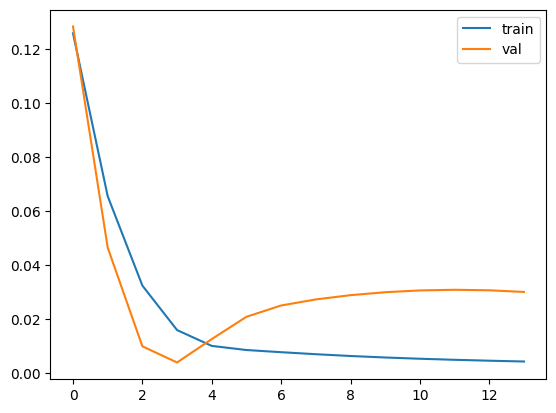

4/4 [==============================] - 0s 3ms/step
mae: 4.328388471560857


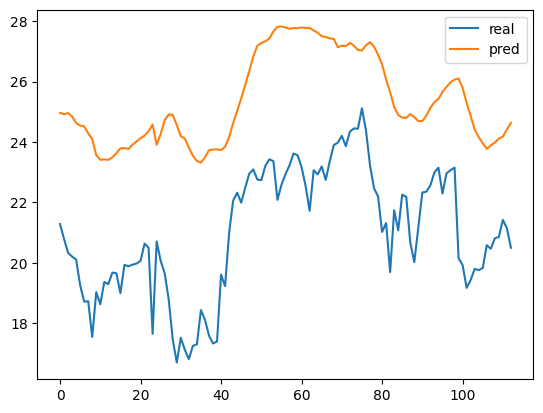

Epoch 1/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.1324 - val_loss: 0.1291
Epoch 2/1000
29/29 [==============================] - 0s 15ms/step - loss: 0.0694 - val_loss: 0.0453
Epoch 3/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.0333 - val_loss: 0.0123
Epoch 4/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0161 - val_loss: 0.0109
Epoch 5/1000
29/29 [==============================] - 0s 15ms/step - loss: 0.0106 - val_loss: 0.0181
Epoch 6/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0090 - val_loss: 0.0197
Epoch 7/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0178
Epoch 8/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0153
Epoch 9/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0127
Epoch 10/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.0058 - val_lo

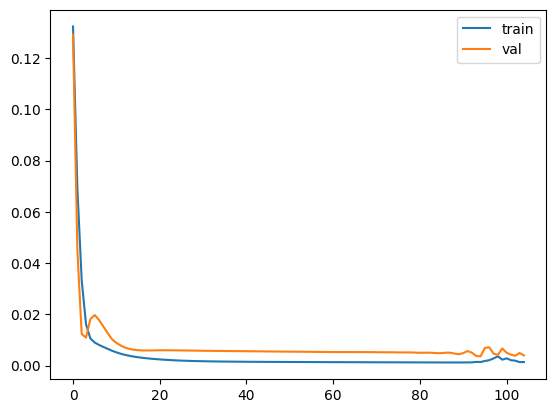

4/4 [==============================] - 0s 2ms/step
mae: 2.116791330407607


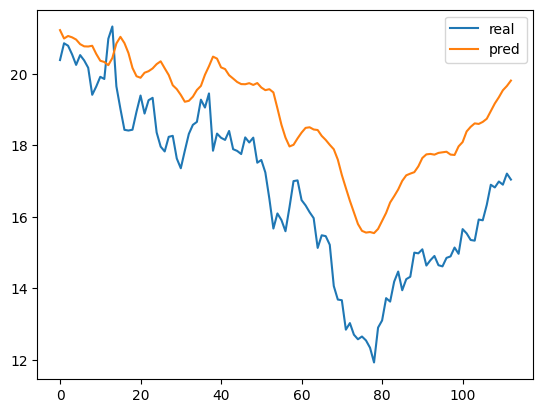

Epoch 1/1000
32/32 [==============================] - 1s 8ms/step - loss: 0.1207 - val_loss: 0.0584
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0476 - val_loss: 0.0118
Epoch 3/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0184 - val_loss: 0.0212
Epoch 4/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0112 - val_loss: 0.0391
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0415
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0376
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0330
Epoch 8/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0278
Epoch 9/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0223
Epoch 10/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0187

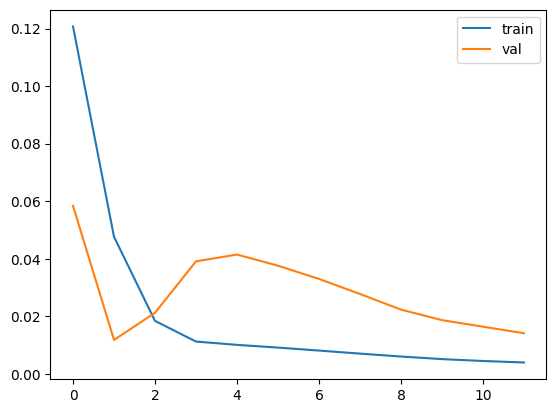

4/4 [==============================] - 0s 2ms/step
mae: 1.8798008359061722


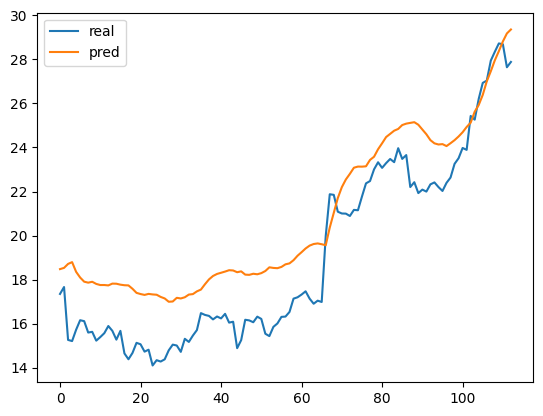

In [112]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    model=build_model(input_shape=(X_train.shape[1],X_train.shape[2]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    

    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)


    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()


In [113]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 64)                20992     
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
average_mae=np.mean(maes)

print('average mae:',average_mae)

average mae: 1.9564149711115746
